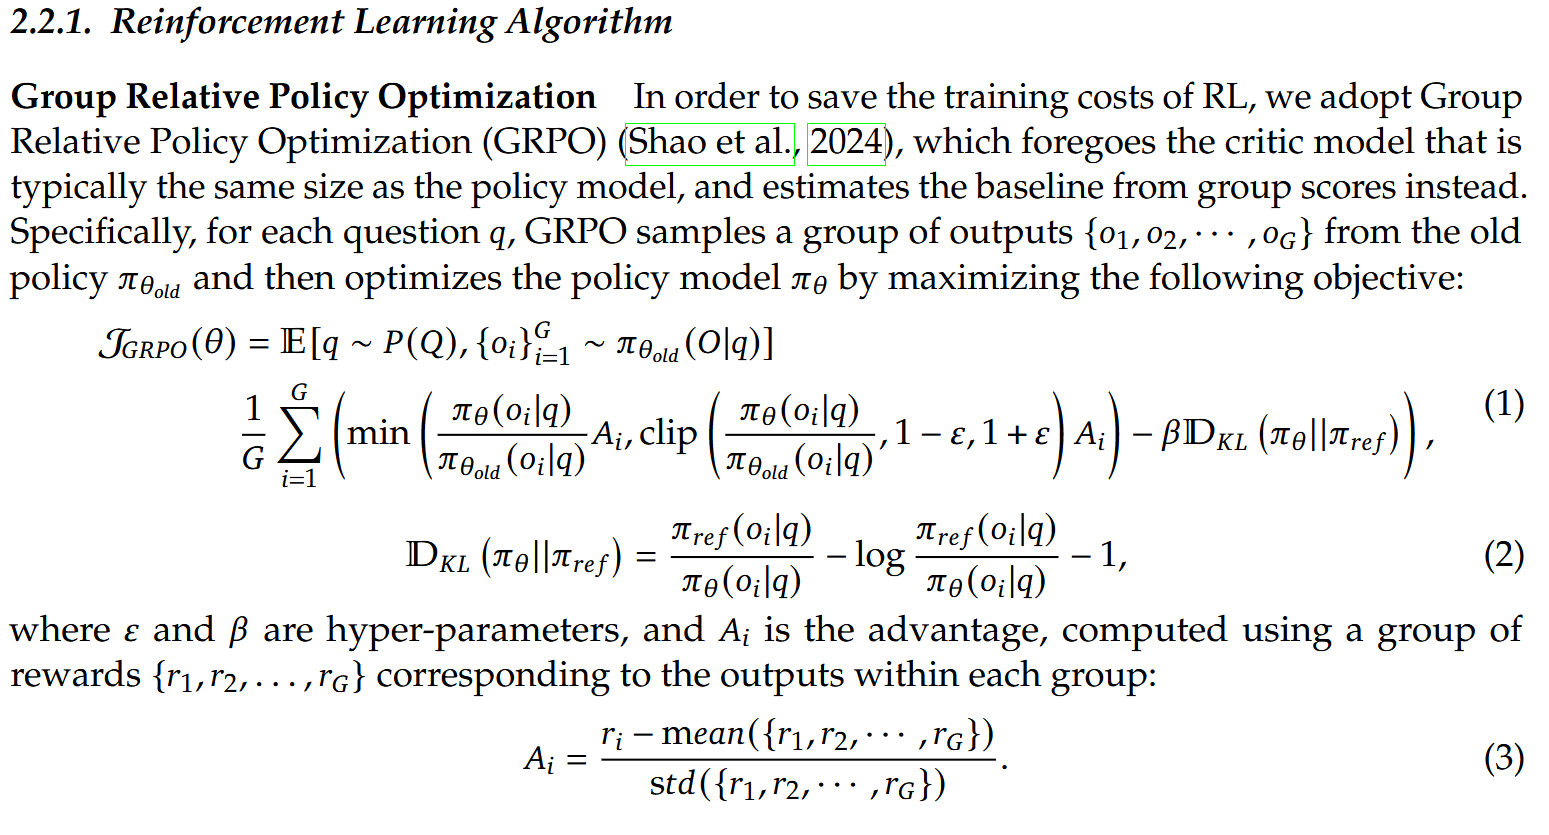

Image Credit Deepseek r1 Paper (https://arxiv.org/abs/2501.12948)


# Group Relative Policy Optimization in PyTorch

This is a very bare-bones implementation of GRPO using PyTorch. If you want to learn more, I recommend reading the paper or looking up other tutorials online. I have done this with very little outside reference other than the image above; therefore it is likely not correctly implemented in some way. (I literally had no idea how reinforcement learning worked like 3 days ago, and to be honest I still probably don't)

That aside, Group Relative Policy Optimization, in my limited understanding, is an RL method that trains a language model without the use of a critic model. 

This is made possible by the fact that it is possible to find the probability that a model defines to an entire sequence of tokens.
This probability is represented by something along the lines of $\displaystyle P(x) = \prod_{i=0}^{n} \pi_\theta(x_i | x_0 ... x_{i-1})$

Where $P(x)$ is the probability of the sequence $x$ of length $n$ assigned by the model $\pi_\theta$.

In practice, we can feed context into the model, store the probability of each token ( = softmaxed logits indexed at the desired token) for later and multiply this (with some numerical stability tricks) to get the probability of the model's output.

This probability is then compared to the probability assigned by the "old" model, which is just a copy of the new model that is behind by one optimization step. The two probabilites are divided to get the ratio $\displaystyle \frac{\pi_\theta(o_i|q)}{\pi_{\theta_{old}}(o_i|q)}$. This is then multiplied by the advantage for the current step (more or less the reward). A positive advantage and a ratio > 1 means that the new model assigned a higher probability to a sequence than the old model, and that sequence was desired. This is then clipped for training stability.

Another term $D_{KL}$ is subtracted from the objective, which is just a comparison of the proabilities from the new model and the base (un-tuned) model to prevent too much divergence. 

We try to maximize the objective with gradient ascent, which is possible because the probabilities can be represented as functions of the model's parameters.

# Set up model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.set_default_device("cuda")

In [2]:
import requests
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
raw_data = requests.get(url).text
raw_data[0:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [3]:
vocab = sorted(set("".join(raw_data)))
stoi = {char:i for i, char in enumerate(vocab)}
itos = {i:char for i, char in enumerate(vocab)}
itos[stoi["a"]]

'a'

In [4]:
class DataLoader:
    def __init__(self, tokens, B, T):
        self.tokens = torch.tensor(tokens)
        self.B = B
        self.T = T
        self.current_pos = 0
        self.num_tokens = len(tokens)
    def next(self):
        if self.current_pos + (self.B * self.T + 1) >= self.num_tokens:
            self.current_pos = 0
        buf = self.tokens[self.current_pos:self.current_pos + self.B * self.T + 1]
        x_buf = buf[:-1].view(self.B, self.T)
        y_buf = buf[1:].view(self.B, self.T)
        self.current_pos += self.B * self.T
        return x_buf, y_buf


tokenized_data = [stoi[char] for char in raw_data]
train_amount = 0.9
train_tokens = tokenized_data[:int(len(tokenized_data)*train_amount)]
val_tokens = tokenized_data[int(len(tokenized_data)*train_amount):]

B = 4
T = 8
train_dl = DataLoader(train_tokens, B, T)
val_dl = DataLoader(val_tokens, B, T)

train_dl.next()

(tensor([[18, 47, 56, 57, 58,  1, 15, 47],
         [58, 47, 64, 43, 52, 10,  0, 14],
         [43, 44, 53, 56, 43,  1, 61, 43],
         [ 1, 54, 56, 53, 41, 43, 43, 42]], device='cuda:0'),
 tensor([[47, 56, 57, 58,  1, 15, 47, 58],
         [47, 64, 43, 52, 10,  0, 14, 43],
         [44, 53, 56, 43,  1, 61, 43,  1],
         [54, 56, 53, 41, 43, 43, 42,  1]], device='cuda:0'))

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_key = d_model // n_heads

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        self.wo = nn.Linear(d_model, d_model)
    def forward(self, x):
        B, T, C = x.size()
        Q = self.wq(x).view(B, T, self.n_heads, self.d_key).transpose(1, 2)
        K = self.wk(x).view(B, T, self.n_heads, self.d_key).transpose(1, 2)
        V = self.wv(x).view(B, T, self.n_heads, self.d_key).transpose(1, 2)

        attn_scores = F.scaled_dot_product_attention(Q, K, V, is_causal=True).transpose(1, 2).view(B, T, C)
        return self.wo(attn_scores)

mha = MultiHeadAttention(768, 12)
x = torch.randn((4, 12, 768))
assert mha(x).size() == x.size()
print("we chillin")

we chillin


In [6]:
class MLP(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size

        self.l1 = nn.Linear(in_size, hidden_size)
        self.act = nn.GELU()
        self.l2 = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        return self.l2(self.act(self.l1(x)))

mlp = MLP(768, 768 * 4, 768)
x = torch.randn((4, 12, 768))
assert mlp(x).size() == x.size()
print("🥶🥶🥶")

🥶🥶🥶


In [7]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ln1 = nn.LayerNorm(d_model)
        self.mlp = MLP(d_model, d_model * 4, d_model)
        self.ln2 = nn.LayerNorm(d_model)
        
    def forward(self, x):
        x = x + self.mha(x)
        x = self.ln1(x)
        x = x + self.mlp(x)
        x = self.ln2(x)
        return x

db = DecoderBlock(768, 12)
x = torch.randn((4, 12, 768))
assert db(x).size() == x.size()
print("⚠️subzero temperatures⚠️")

⚠️subzero temperatures⚠️


In [8]:
class GPT(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, vocab_size, max_positions):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.vocab_size = vocab_size
        self.max_positions = max_positions
        self.n_layers = n_layers
        
        self.emb = nn.Embedding(vocab_size, d_model)
        self.pos = nn.Embedding(max_positions, d_model)

        self.decoder_stack = nn.ModuleList([
            DecoderBlock(d_model, n_heads) for _ in range(n_layers)
        ])

        self.out_proj = nn.Linear(d_model, vocab_size)
    def forward(self, x):
        B, T = x.size()
        x = self.emb(x)
        x = x + self.pos(torch.arange(T))
        for db in self.decoder_stack:
            x = db(x)
        return self.out_proj(x)

gpt = GPT(
    d_model=768,
    n_heads=12,
    n_layers=12,
    vocab_size=len(vocab),
    max_positions=1024
)
x = train_dl.next()[0]
assert gpt(x).size(0) == x.size(0) and gpt(x).size(1) == x.size(1)
print("🧊🧊🧊entering ice age🧊🧊🧊")

🧊🧊🧊entering ice age🧊🧊🧊


# Finding $\frac{\pi_\theta(o_i|q)}{\pi_{\theta_{old}}(o_i|q)}$ for a single example

In [9]:
# probability for a single token
prompt = "ROMEO:"
tokens = torch.tensor([stoi[char] for char in prompt]).view(1, -1)
logits = gpt(tokens)[:, -1]
probs = F.softmax(logits, dim=-1)
print(probs.size())
selected_index = torch.multinomial(probs, num_samples=1)
print(f"Selected {itos[selected_index.item()]} with probability {probs[0, selected_index].item()}")

torch.Size([1, 65])
Selected K with probability 0.026930075138807297


In [10]:
# we want to store the probabilites of each token that was sampled
# and multiply them together to get the probability of the sequence as a whole
# assigned by the model
saved_probabilities = []
prompt = "ROMEO:"
outputs = ""

for _ in range(10):
    # tokenize prompt and feed into gpt
    tokens = torch.tensor([stoi[char] for char in (prompt + outputs)]).view(1, -1)
    logits = gpt(tokens)[:, -1]
    probs = F.softmax(logits, dim=-1)
    # sample from the model's output distribution for a token index
    selected_index = torch.multinomial(probs, num_samples=1)
    # add that token to the outputs
    outputs += itos[selected_index.item()]
    # save the probability at that token
    saved_probabilities.append(probs[0, selected_index])

print(prompt)
print(outputs)
for prob in saved_probabilities:
    print(f"{prob.item():.3f}", end=" ")

total_probability = 1.0
for prob in saved_probabilities:
    total_probability = total_probability * prob
total_probability

ROMEO:
samhA!jk.r
0.020 0.016 0.013 0.019 0.015 0.027 0.022 0.046 0.017 0.033 

tensor([[1.8640e-17]], device='cuda:0', grad_fn=<MulBackward0>)

# Quick pretraining

Very simple implementation here, if you want to learn more I would highly recommand Andrej Karpathy's videos on both neural networks and training GPT-2

In [11]:
B, T = 8, 128
train_dl = DataLoader(train_tokens, B, T)
num_steps = 1000

optim = torch.optim.AdamW(gpt.parameters(), lr=3e-4)
for step in range(num_steps):
    xb, yb = train_dl.next()
    pred = gpt(xb)
    loss = F.cross_entropy(pred.view(-1, logits.size(-1)), yb.view(-1))

    optim.zero_grad()
    loss.backward()
    optim.step()

    if step % 100 == 0:
        print(f"step {step} | loss {loss.item():.4f}")

step 0 | loss 4.4155
step 100 | loss 3.1877
step 200 | loss 3.3899
step 300 | loss 3.3064
step 400 | loss 3.2709
step 500 | loss 3.2615
step 600 | loss 3.1902
step 700 | loss 3.3334
step 800 | loss 3.1826
step 900 | loss 3.4311


# Training the model to output "e" with GRPO

In [12]:
from copy import deepcopy

In [13]:
import random

In [14]:
# make our new model
new_gpt = GPT(
    d_model=768,
    n_heads=12,
    n_layers=12,
    vocab_size=len(vocab),
    max_positions=1024
)
last_state_dict = deepcopy(gpt.state_dict()) # get a copy of the current state_dict
new_gpt.load_state_dict(last_state_dict) # load it into the new model
# modify it a little bit so the models aren't the same at initialization (maybe not necessary idk)
new_gpt.out_proj.weight.data += torch.randn(new_gpt.out_proj.weight.size()) * (0.1 * new_gpt.out_proj.weight.std())

# make a reference copy of the pretrained model
# so we can compare it to the new model at each step
# and penalize divergence
ref_gpt = GPT(
    d_model=768,
    n_heads=12,
    n_layers=12,
    vocab_size=len(vocab),
    max_positions=1024
)
ref_gpt.load_state_dict(deepcopy(gpt.state_dict()))

# epsilon controls loss clipping, smaller values should in theory be more stable
epsilon = 0.1
# beta is how much we want to punish drifting away from the original model
beta = 0.25
# G is like batch size (num sequences)
G = 8


# training loop
for step in range(100):
    # store all our rewards and ratios
    rewards = []
    ratios = []
    ref_ratios = []
    # for each example in the batch,
    # have the old model generate a sequence using the prompt
    # the probability of this sequence is the product of the probabilities
    # for each token in the sequence
    # e.g, we randomly sample the token "c" from the output probs, and it had a probability of 0.2
    # then the next token sampled has a probability of 0.4, so the total probability for the sequence is 0.2*0.4=0.08

    # this is not numerically stable at all bc we get super tiny numbers
    # but if we take the log of each of the probs, add them up, we get a decently reasonable number
    # this is the same as the log of each of the probs multiplied
    # then we can do it for the new model and old model, subtract them (same as division because of logs)
    # and then exponentiate the result to get a reasonable ratio that is numerically stable
    for i in range(G):
        # lists of saved probabilites for calculating ratios later
        # maybe there is a better way to do this idk
        saved_probabilities_old = []
        saved_probabilities = []
        saved_probabilities_ref = []
        # get a random prompt
        prompt = random.choice(["ROMEO:", "sup", "heheh", "eee", "MERCUTIO:"])
        # initialize the outputs from the old model to an empty string
        old_outputs = ""
        
        # sequence length of 24 tokens becuase it takes too long otherwise
        # old model
        for x in range(24):
            # get the current tokens (prompt + outputs) into a tensor
            old_tokens = torch.tensor([stoi[char] for char in (prompt + old_outputs)]).view(1, -1)
            # inference with the old model, get probs
            old_logits = gpt(old_tokens)[:, -1]
            old_probs = F.softmax(old_logits, dim=-1)
            # sample a token index from the model (in theory any sampling technique should work)
            old_selected_index = torch.multinomial(old_probs, num_samples=1)
            # add the model's selected token to the output
            old_outputs += itos[old_selected_index.item()]
            # save the probability of that token for later
            saved_probabilities_old.append(old_probs[0, old_selected_index.item()])
        
        # new model
        for x in range(24):
            # inference the new model on the old model's outputs
            # if it's more likely and the associated rewards are higher, the objective will go up
            tokens = torch.tensor([stoi[char] for char in (prompt + old_outputs[:x])]).view(1, -1)
            logits = new_gpt(tokens)[:, -1]
            probs = F.softmax(logits, dim=-1)
            # save the probs for ratio calculation
            saved_probabilities.append(probs[0, stoi[old_outputs[x]]])

        # reference model
        for x in range(24):
            # same thing as before, but for this we will compare it with the new model
            # to make sure divergence isn't too high
            tokens = torch.tensor([stoi[char] for char in (prompt + old_outputs[:x])]).view(1, -1)
            logits = ref_gpt(tokens)[:, -1]
            probs = F.softmax(logits, dim=-1)
            saved_probabilities_ref.append(probs[0, stoi[old_outputs[x]]])

        # calculate the ratio using log tricks (basically the same as multiplying all the probs in each sequence and comparing)
        ratio = torch.exp(sum(prob.log() for prob in saved_probabilities) - sum(old_prob.log() for old_prob in saved_probabilities_old))
        # do the same for the reference model and new model so the new model doesn't drift to far
        ref_ratio = torch.exp(sum(ref_prob.log() for ref_prob in saved_probabilities_ref) - sum(prob.log() for prob in saved_probabilities))
        # save the ratios for later
        ratios.append(ratio)
        ref_ratios.append(ratio)
        
        # calculate the reward
        # this doesn't need to be a differentiable function or anything, just a float
        # if you like the output, make reward higher
        # if you don't, make the reward smaller
        # here i'm just having it be the number of e's in the output
        # because it's easy to tell if it has learned
        reward = float(old_outputs.count("e"))
        # save the reward for later
        rewards.append(reward)

    # initialize objective to zero
    # there's probably a better term to use but i like objective
    # it's more or less the opposite of loss
    objective = 0.0
    # go through all the ratios and rewards
    for ratio, ref_ratio, reward in zip(ratios, ref_ratios, rewards):
        # normalize the rewards, calculate advantage based on current reward
        reward_mean = sum(rewards) / len(rewards)
        reward_std = (sum((x_i - reward_mean)/len(rewards) for x_i in rewards))**0.5
        # i might be doing this wrong
        advantage = (reward - reward_mean) / (reward_std + 1)

        # calculate divergence penalty
        d_kl = ref_ratio - ref_ratio.log() - 1

        # add to the objective
        # divide by batch size so we get an average

        # the clip is for numerical stability,
        # but basically we want the ratio to be higher when the advantage is higher
        # and not to drift too far from original model
        objective += (min(ratio * advantage, torch.clip(ratio, 1 - epsilon, 1 + epsilon)*advantage) - beta * d_kl)/ G
    
    # update gradients
    for p in new_gpt.parameters():
        p.grad = None
    objective.backward()

    # copy the current state dict, give it to the old gpt for next time
    last_state_dict = deepcopy(new_gpt.state_dict())
    gpt.load_state_dict(last_state_dict)

    # update new gpt's state dict
    for p in new_gpt.parameters():
        p.data += 1e-4 * p.grad

    if step % 10 == 0:
        print(f"step {step} | objective {objective}")

step 0 | objective -0.06100897490978241
step 10 | objective 0.1400187611579895
step 20 | objective 0.02745574712753296
step 30 | objective -0.254213809967041
step 40 | objective -0.011362176388502121
step 50 | objective 0.003920048475265503
step 60 | objective 0.008717350661754608
step 70 | objective 0.0032442212104797363
step 80 | objective 0.006601549685001373
step 90 | objective 0.0037964750081300735


# Sample from the model

Here, we should expect an output with mostly or all e's, because our reward was based on the number of e's in the output

In [15]:
prompt = "ROMEO:"
outputs = ""
for _ in range(10):
    tokens = torch.tensor([stoi[char] for char in (prompt + outputs)]).view(1, -1)
    logits = gpt(tokens)[:, -1]
    probs = F.softmax(logits, dim=-1)
    selected_index = torch.multinomial(probs, num_samples=1)
    outputs += itos[selected_index.item()]
outputs

'eeeeeeeeee'

IT WORKS NO WAY AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA